<a href="https://colab.research.google.com/github/ekqlsrla/ESAA-2/blob/main/Project/%5B%EC%88%98%EC%83%81%EC%9E%91%EB%A6%AC%EB%B7%B0%5D_%EC%9B%94%EA%B0%84_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%86%8C%EC%84%A4_%EC%9E%91%EA%B0%80_%EB%B6%84%EB%A5%98_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[수상작 리뷰] 월간 데이콘 소설 작가 분류 AI 경진대회**

* 알고리즘 | NLP | 분류 | 자연어 | LogLoss

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

---
# 1. NLP Preprocessing

## (1) 데이터 불러오기

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA-2/DATA/235670_소설 작가 분류 AI 경진대회_data/train.csv')
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [4]:
test  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA-2/DATA/235670_소설 작가 분류 AI 경진대회_data/test_x.csv')
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [5]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA-2/DATA/235670_소설 작가 분류 AI 경진대회_data/sample_submission.csv')

## (2) 불용어 제거

In [6]:
#부호 제거 함수

def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

#불용어 제거 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

#불용어 
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


#소문자로 바꿈
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

## (3) 데이터 시각화

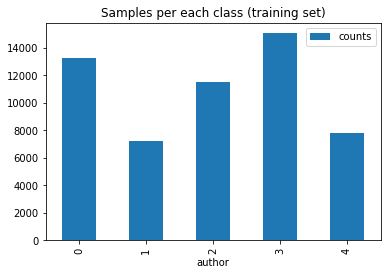

In [ ]:
#작가별 분포도 확인

train.groupby(train.author).size().reset_index(name = 'counts').plot.bar(x = 'author', title = 'Samples per each class (training set)')

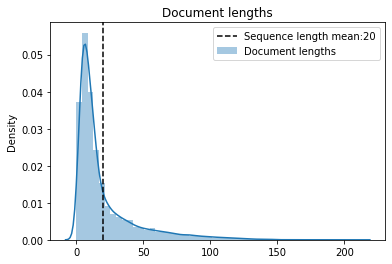

 가장 긴 문장은 211 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [ ]:
# 문장 길이 분포도 확인
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

-> 문장의 **평균 길이**는 20이고, 차후 **sequence**에 적용할 **max length**는 150정도로 잡음

---
# 2. Vectorization

## (1) Tokenization

In [7]:
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
Y_train = np.array([x for x in train['author']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(54879,)
(19617,)
(54879,)


In [8]:
print(X_train)
print(X_test)
print(Y_train)

['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity'
 'sister asked suppose'
 'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'
 ... 'sincere wellwisher friend sister lucy odin' 'wanted lend money'
 'certainly not occurred said yes like']
['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment'
 'no replied sudden consciousness not find cannot ignorant goodness owe alli feel iti express couldbut well know no orator'
 'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner heard mr odin darted much ag

* `Tokenizer` : 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 **num_words**에 지정된 만큼만 숫자로 반환하고, 나머지는 0으로 반환

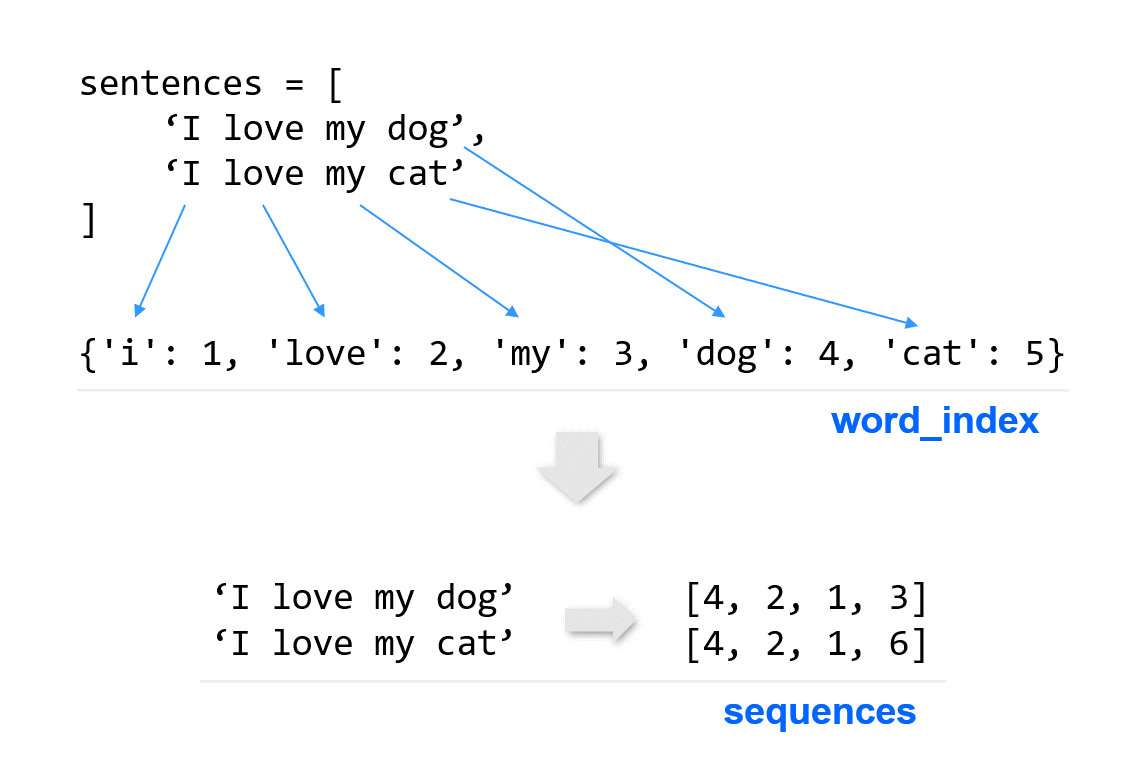

In [9]:
#Tokenizer

from keras.preprocessing.text import Tokenizer
vocab_size = 2000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

print(len(sequences_train), len(sequences_test))

54879 19617


---
# 3. Embedding

In [10]:
#변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성

word_index = tokenizer.word_index

* 문장의 길이가 제각각 -> 벡터 크기 다름 
* **패딩 작업**을 통해 최대 시퀀스 길이를 늘리고 **빈 공간을 0으로 채움**

In [11]:
#독립변수 데이터 전처리

max_length = 150
padding_type = 'post'

train_x = pad_sequences(sequences_train, padding = 'post', maxlen = max_length)
test_x = pad_sequences(sequences_test, padding = padding_type, maxlen = max_length)

print(train_x.shape, test_x.shape)

(54879, 150) (19617, 150)


In [12]:
#종속 변수 데이터 전처레

train_y = np_utils.to_categorical(Y_train)
print(train_y)
print(train_y.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(54879, 5)


---

# 4. Modeling

## (1) simple RNN

In [ ]:
#파라미터 설정

vocab_size = 2000
embedding_dim = 200
max_length = 150
padding_type = 'post'

### **SimpleRNN 레이어**를 사용한 모델 정의

* 결괏값 0~4 -> Dense (5)
* 여러 개 정답중 하나 맞추는 문제 -> `손실 함수 : categorical_crossentropy`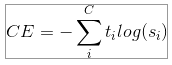

In [ ]:
#model 1 정의

model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
                     tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
                     tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
                     tf.keras.layers.SimpleRNN(units = 64),
                     Dense(5, activation = 'softmax') 

                     ])

model1.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          400000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 150, 64)           16960     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 433,797
Trainable params: 433,797
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model1.fit(train_x,train_y, epochs = 10, batch_size = 100, validation_split = 0.2)

Epoch 1/10
440/440 [==============================] - 115s 254ms/step - loss: 1.5807 - accuracy: 0.2629 - val_loss: 1.5802 - val_accuracy: 0.2111
Epoch 2/10
440/440 [==============================] - 108s 246ms/step - loss: 1.5735 - accuracy: 0.2720 - val_loss: 1.5751 - val_accuracy: 0.2472
Epoch 3/10
440/440 [==============================] - 107s 243ms/step - loss: 1.5738 - accuracy: 0.2689 - val_loss: 1.5739 - val_accuracy: 0.2472
Epoch 4/10
440/440 [==============================] - 108s 246ms/step - loss: 1.5732 - accuracy: 0.2717 - val_loss: 1.5718 - val_accuracy: 0.2472
Epoch 5/10
440/440 [==============================] - 107s 242ms/step - loss: 1.5731 - accuracy: 0.2686 - val_loss: 1.5717 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 107s 244ms/step - loss: 1.5729 - accuracy: 0.2719 - val_loss: 1.5721 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 106s 241ms/step - loss: 1.5732 - accuracy: 0.2714 - val_loss: 1.5740 -

<function matplotlib.pyplot.show(*args, **kw)>

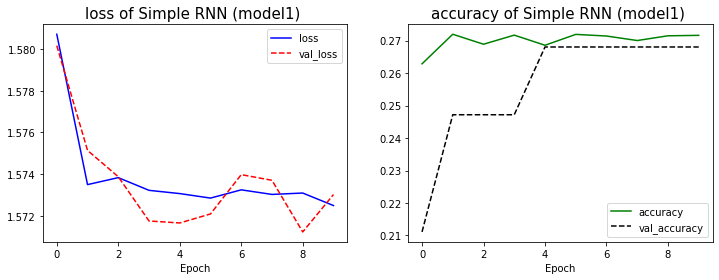

In [ ]:
plt.figure(figsize=(12, 4))
plt.title('Simple RNN (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

-> **Epoch**시간도 오래걸리고 학습이 잘 되지 않음

## (2) 단방향 LSTM

In [13]:
#파라미터 설정
vocab_size = 2000
embedding_dim = 200  
max_length = 150   
padding_type='post'

### **LSTM** 레이어를 사용한 모델2 정의

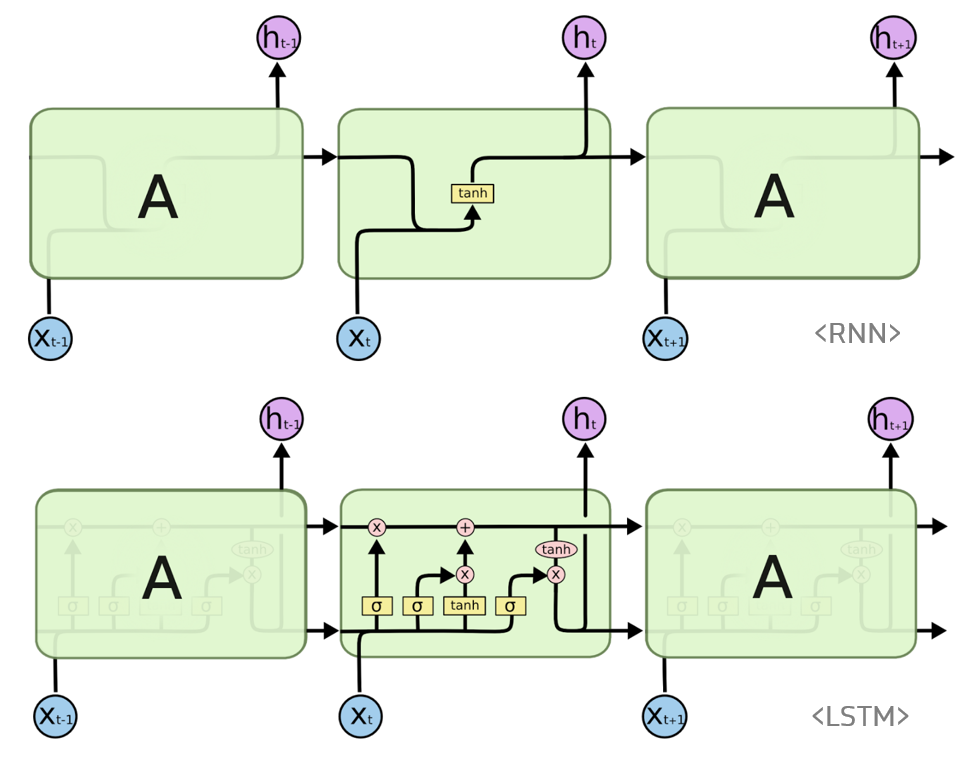

In [14]:
# LSTM 레이어를 사용한 모델 (model2) 정의
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(5, activation='softmax')    
    ])
    
model2.compile(loss= 'categorical_crossentropy', 
              metrics = ['accuracy']) 
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          400000    
                                                                 
 lstm (LSTM)                 (None, 150, 64)           67840     
                                                                 
 lstm_1 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 534,213
Trainable params: 534,213
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 

Epoch 1/10
440/440 [==============================] - 443s 992ms/step - loss: 1.5724 - accuracy: 0.2748 - val_loss: 1.5744 - val_accuracy: 0.2680
Epoch 2/10
440/440 [==============================] - 442s 1s/step - loss: 1.5708 - accuracy: 0.2759 - val_loss: 1.5808 - val_accuracy: 0.2680
Epoch 3/10
440/440 [==============================] - 461s 1s/step - loss: 1.5709 - accuracy: 0.2761 - val_loss: 1.5727 - val_accuracy: 0.2680
Epoch 4/10
440/440 [==============================] - 456s 1s/step - loss: 1.5705 - accuracy: 0.2761 - val_loss: 1.5724 - val_accuracy: 0.2680
Epoch 5/10
440/440 [==============================] - 465s 1s/step - loss: 1.5705 - accuracy: 0.2761 - val_loss: 1.5719 - val_accuracy: 0.2680
Epoch 6/10
440/440 [==============================] - 462s 1s/step - loss: 1.5704 - accuracy: 0.2761 - val_loss: 1.5713 - val_accuracy: 0.2680
Epoch 7/10
440/440 [==============================] - 471s 1s/step - loss: 1.5703 - accuracy: 0.2761 - val_loss: 1.5723 - val_accuracy: 0.2

In [ ]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

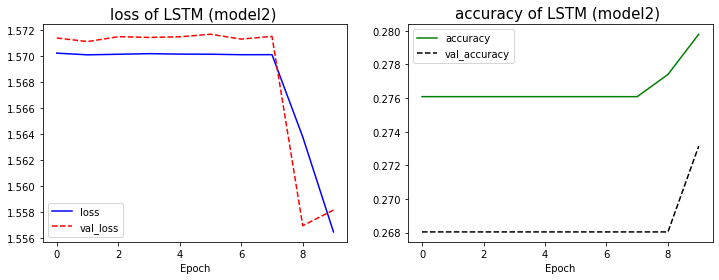

-> 학습시간은 **단축**되었으나, 학습이 아직 잘 이루어지지 않음

## (3) 양방향 LSTM


In [ ]:
#파라미터 설정
vocab_size = 2000 
embedding_dim = 200  
max_length = 150    
padding_type='post'

### **양방향 LSTM 레이어**를 사용한 모델3 정의

In [ ]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(5, activation='softmax')   
    ])
    
model3.compile(loss= 'categorical_crossentropy', 
              optimizer= 'adam',
              metrics = ['accuracy']) 
model3.summary()

In [ ]:
# 모델 실행해보기 -> epcoch 50
history = model3.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 

In [ ]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

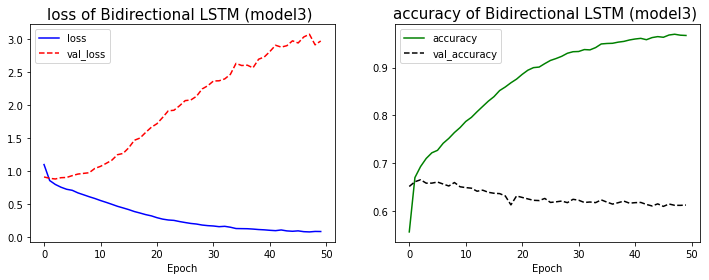

-> **loss**값은 줄어들고 있으나. **val_loss**는 증가하고 있으며 **val_accuracy**는 제대로 결과가 나오지 않고 있음  -> `교차검증` 

## (4) 교차 검증 적용

In [ ]:
#계층 교차 검증
n_fold = 5
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)

for i, (i_trn,i_val) in enumerate(cv.split(train_x, Y_train),1) :
  print('training model for CV #{i}')

  model3.fit(train_x[i_trn],
             to_categorical(Y_train[i_trn],
             validation_data = (train_x[i_val], to_categorical(Y_train[i_val])),
             epochs = 10,
             batch_size = 512))

In [ ]:
#조기 종료 옵션 추가

n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 5))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model3.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

## (5) 테스트 데이터 적용

In [ ]:
test_y

In [ ]:
# sample_submission 에 대입
sample_submission[['0','1','2','3','4']] = test_y
sample_submission